**Still to do:**  
- evaluate to remove outliers, especially for K-Means, using DBScan to detect them
- compare the results of the three clustering approaches
- give more insights on the clustering results
- comment better the code and the results

Data Mining project  
AA 2022/23  
Task 2  
Group 12  
Leonardo Vona  
545042  

05/11/2022

# **Clustering**

In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score 
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples
import seaborn as sn
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import mode
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [8]:
users_df = pd.read_csv('./users_edited.csv', sep=',', index_col=0)

In [9]:
users_df

,name,lang,bot,created_at,statuses_count,num_tweets,num_retweets,avg_tweets_per_day,avg_retweets_per_tweet,avg_replies_per_tweet,...,cumulative_retweets,cumulative_replies,cumulative_favorites,cumulative_hashtags,cumulative_urls,cumulative_mentions,avg_tweet_length,entropy_hour,entropy_text_length,entropy_publication_rate
id,,,,,,,,,,,,,,,,,,,,,
2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,118,0,0.944000,0.033898,0.0,...,4.0,0.0,5.0,13.0,0.0,35.0,63.0,2.551728,4.260846,3.117709
2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,104,0,0.832000,0.028846,0.0,...,3.0,0.0,6.0,3.0,0.0,38.0,70.0,2.289363,4.129301,2.927789
137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,3,0,3.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,17.0,1.098612,1.098612,0.061140
466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,1243,6,1.373481,0.074014,0.0,...,92.0,0.0,240.0,78.0,32.0,1.0,89.0,2.899550,4.676458,6.346154
2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,3175,0,26.239669,0.017638,0.0,...,56.0,0.0,205.0,431.0,3.0,1718.0,75.0,3.169970,4.758071,7.656939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,644,175,5.551724,0.026398,0.0,...,17.0,0.0,59.0,108.0,8.0,341.0,42.0,2.551332,4.460530,4.949455
1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,1633,109,2.224796,0.015309,0.0,...,25.0,0.0,419.0,182.0,159.0,814.0,57.0,2.804941,4.723266,6.167495
126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6,6,0,0.006250,0.000000,0.0,...,0.0,0.0,0.0,2.0,4.0,2.0,68.0,1.329661,1.791759,0.880575


## **Preprocessing**

### **Dividing the dataset**

I divide the user features into categorical and numerical, into the dataframes cat_df and num_df, respectively. I put the feature 'created_at' into the categorical dataframe even if it is not a categorical attribute because for the clustering it can't be used.

In [10]:
cat_df = users_df[['bot', 'name', 'lang', 'created_at']]

In [11]:
num_df = users_df[users_df.columns.difference(['id', 'bot', 'name', 'lang', 'created_at'])]

### **Elimination of highly correlated features**

Highly correlated features may turn into a problem for the clustering analysis. There is an high correlation (greater than 0.9) between:
- avg_favorites_per_tweet and cumulative_favorites
- avg_retweets_per_tweet and cumulative_retweets
- cumulative_favorites and cumulative_retweets  
For this reason I decided to drop the features cumulative_favorites and cumulative_retweets.

In [12]:
corr_threshold = 0.9
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(num_df.columns)):
    for j in range(i+1, len(num_df.columns)):
        corr = num_df[num_df.columns[i]].corr(num_df[num_df.columns[j]])
        if  corr > corr_threshold:
            print(num_df.columns[i] + "\t" + num_df.columns[j] + "\t" + '{:.4f}'.format(corr))

Att. A	Att. B	Corr(A,B)
avg_favorites_per_tweet	cumulative_favorites	0.9101
avg_retweets_per_tweet	cumulative_retweets	0.9601
cumulative_favorites	cumulative_retweets	0.9190


In [13]:
num_df = num_df.drop(['cumulative_favorites', 'cumulative_retweets'], axis=1)

### **Normalization**

Before starting the clustering analysis, the numerical features are normalized using a MinMaxScaler.

In [14]:
scaler = MinMaxScaler()
users_norm = scaler.fit_transform(num_df.values)

## **K-means**

### **Determine K**

To determine candidate values for the best K in K-means, I use the elbow and silhouette analysis.

#### **Elbow**

Into the 'clusterings' array I will put the most promising candidate clusterings.

In [103]:
clusterings = []

From the elbow method I obtain as candidate K the value 8.

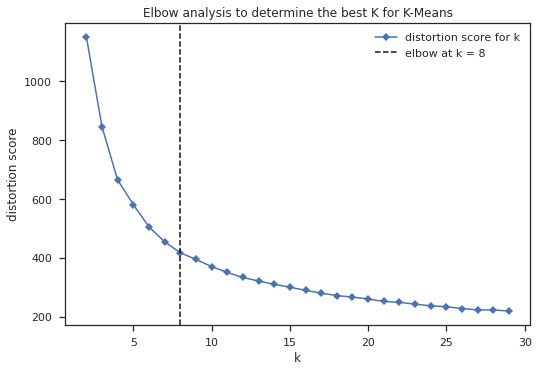

In [104]:
k_min = 2
k_max = 30

vis = KElbowVisualizer(KMeans(), 
                       k=(k_min, k_max), 
                       metric='distortion', 
                       timings=False, 
                       size=(600,400))
vis.fit(users_norm)  
vis.ax.set_ylabel('distortion score')
vis.ax.set_xlabel('k')
vis.ax.set_title('Elbow analysis to determine the best K for K-Means')
plt.legend(['distortion score for k','elbow at k = ' + str(vis.elbow_value_)])

clusterings.append({'type': 'kmeans', 'n_clusters': vis.elbow_value_})

plt.show()

#### **Silhouette**

The silhouette score instead has its peak at value 3.

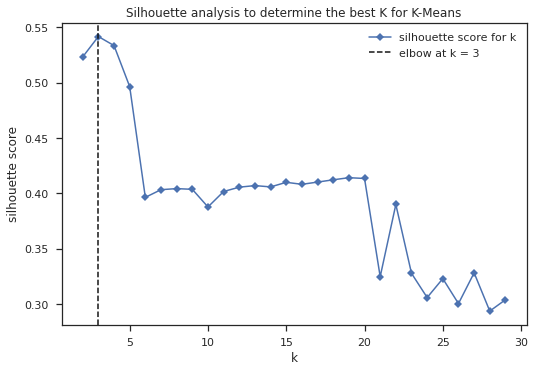

In [105]:
k_min = 2
k_max = 30

vis = KElbowVisualizer(KMeans(), 
                       k=(k_min, k_max), 
                       metric='silhouette', 
                       timings=False, 
                       size=(600,400))
vis.fit(users_norm)  
vis.ax.set_ylabel('silhouette score')
vis.ax.set_xlabel('k')
vis.ax.set_title('Silhouette analysis to determine the best K for K-Means')
plt.legend(['silhouette score for k','elbow at k = ' + str(vis.elbow_value_)])

clusterings.append({'type': 'kmeans', 'n_clusters': vis.elbow_value_})

plt.show()

#### **Comparison**

Now the two candidate values for the K parameter are compared, using the SSE, Davies-Bouldin, Silhouette and Calinski-Harabasz scores.

In [106]:
for i, k in enumerate([clusterings[index]['n_clusters'] for index in range(len(clusterings))]):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100) 
    kmeans.fit(users_norm)

    clusterings[i]['centers'] = kmeans.cluster_centers_
    clusterings[i]['labels'] = kmeans.labels_
    clusterings[i]['sse'] = kmeans.inertia_

In [21]:
k_means_compare_df=pd.DataFrame()

k_means_compare_df['K'] = [clusterings[index]['n_clusters'] for index in range(len(clusterings))]
k_means_compare_df['SSE'] = [clusterings[i]['sse'] for i in range(len(clusterings))]
k_means_compare_df['Davies_Bouldin'] = [davies_bouldin_score(users_norm, clusterings[i]['labels']) for i in range(len(clusterings))]
k_means_compare_df['Silhouette'] = [silhouette_score(users_norm, clusterings[i]['labels']) for i in range(len(clusterings))]
k_means_compare_df['Calinski_Harabasz'] = [calinski_harabasz_score(users_norm, clusterings[i]['labels']) for i in range(len(clusterings))]
k_means_compare_df.set_index(['K'], inplace=True)

k_means_compare_df

,SSE,Davies_Bouldin,Silhouette,Calinski_Harabasz
K,,,,
8,417.816696,1.058941,0.404365,7355.946026
3,845.821047,0.718478,0.541799,9812.475244


- SSE: determines the accuracy of the model, a lower value is better.
- Davies-Bouldin: determines how well the clusters are separated, lower is better  
- Silhouette: gives an indication on how well the clusters are defined, higher is better  
- Calinski_Harabasz: similar to Silhouette, higher is better 
 
From the results it is possible to see that the K-means clustering with 3 clusters performs in general better with respect to the one with 8, even thouugh it has a much higher SSE, which may be caused by outliers.

### **K = 3 evaluation**

I select as K the value 3 and I proceed with the evaluation of the clustering.

In [22]:
kmeans_3 = clusterings[1]

#### **Clustering visualization**

I visualize how the data is separated into the clusters by using PCA to select the two most informative components, and I plot by using these coordinates.

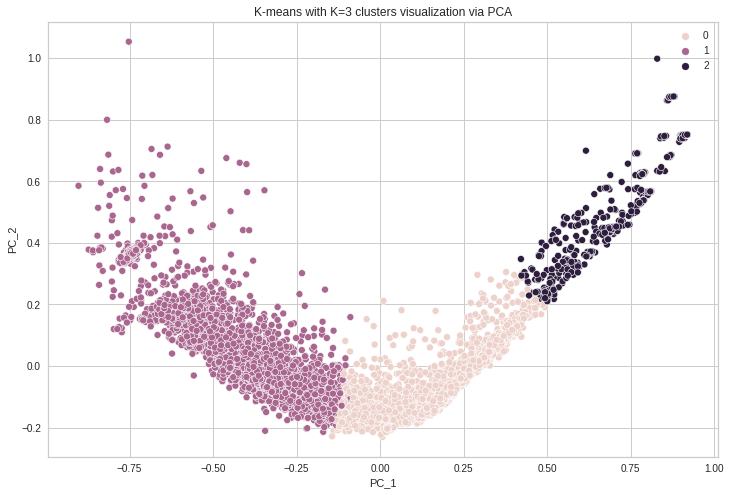

In [23]:
pca = PCA(n_components=2) 
data_to_visualize = pd.DataFrame(pca.fit_transform(users_norm), columns=['PC_1','PC_2'])

centers = pca.fit_transform(kmeans_3['centers'])

fig, ax = plt.subplots(figsize=(12,8))
#ax = sn.scatterplot(x=centers[:, 0], y=centers[:, 1], color='green', s=80, ec='black', legend=False)

ax = sn.scatterplot(x="PC_1",y="PC_2", hue=kmeans_3['labels'], data=data_to_visualize);

ax.set_title('K-means with K=3 clusters visualization via PCA')

plt.show()

By the parallel coordinates plot it is possible to see that there is quite a good separation of the clusters if we consider the entropy features, in particular entropy_publication_rate.

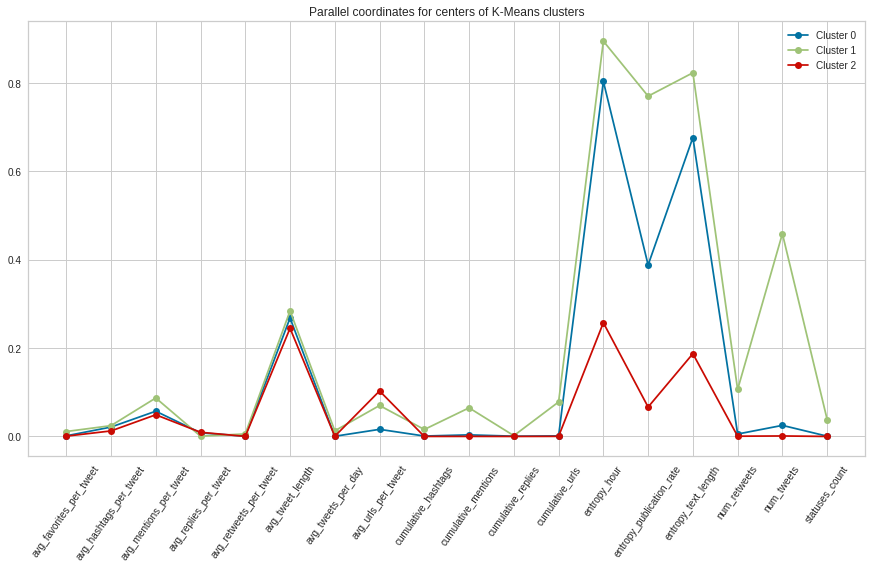

In [24]:
plt.figure(figsize=(15, 8))

for i in range(0, len(kmeans_3['centers'])):
    plt.plot(kmeans_3['centers'][i], marker='o', label='Cluster %s' % (i))
plt.tick_params(axis='both', which='major')
plt.xticks(range(0, len(num_df.columns)), num_df.columns, rotation=55)
plt.legend()
plt.title("Parallel coordinates for centers of K-Means clusters")
plt.show()

If we take the three cluster centers, we can see that:
- the first cluster (cluster 0) groups the most active users, with many tweets associated and an higher variability
- the second cluster (cluster 1) contains medium active users
- the third cluster (cluster 2) contains users with a scarce activity

In [25]:
pd.DataFrame(scaler.inverse_transform(kmeans_3['centers']), columns=num_df.columns)

,avg_favorites_per_tweet,avg_hashtags_per_tweet,avg_mentions_per_tweet,avg_replies_per_tweet,avg_retweets_per_tweet,avg_tweet_length,avg_tweets_per_day,avg_urls_per_tweet,cumulative_hashtags,cumulative_mentions,cumulative_replies,cumulative_urls,entropy_hour,entropy_publication_rate,entropy_text_length,num_retweets,num_tweets,statuses_count
0,0.091172,0.138282,0.249325,0.015201,0.046319,65.655661,0.733694,0.032224,14.685026,34.872608,0.747699,4.964354,2.552297,3.134951,3.758870,16.639445,96.698904,252.801607
1,0.709246,0.158780,0.379845,0.001183,0.361753,69.620906,20.742069,0.140101,241.285886,622.028420,2.168353,299.781551,2.841794,6.220220,4.572881,322.264933,1767.592486,15326.646195
2,0.044696,0.081387,0.214147,0.017505,0.013109,59.964775,0.693800,0.205849,0.986301,1.688845,0.082192,1.037182,0.817380,0.538126,1.040750,1.767123,4.403131,16.070450


The silhouette plot shows that clusters *1* and *2* contains some points with a negative silhouette value. These samples are probably outliers.

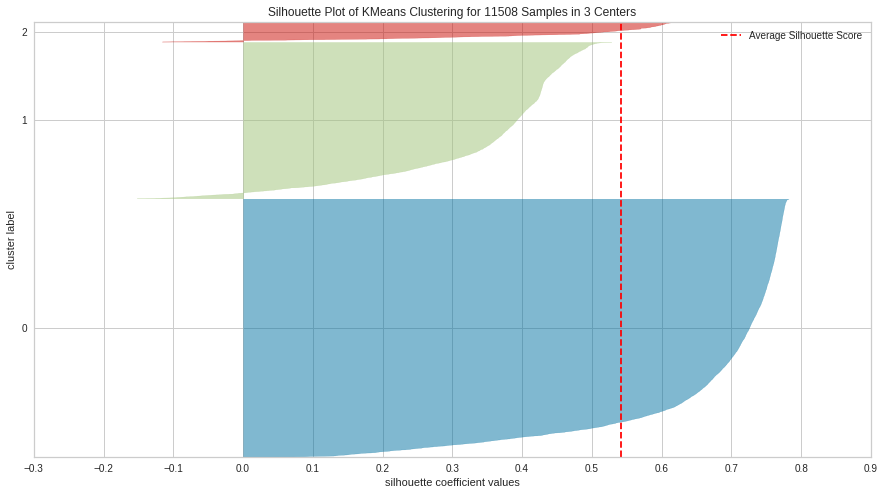

In [26]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(figsize=(15, 8))

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax = ax)

visualizer.fit(users_norm)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [27]:
users_df['label'] = kmeans_3['labels']

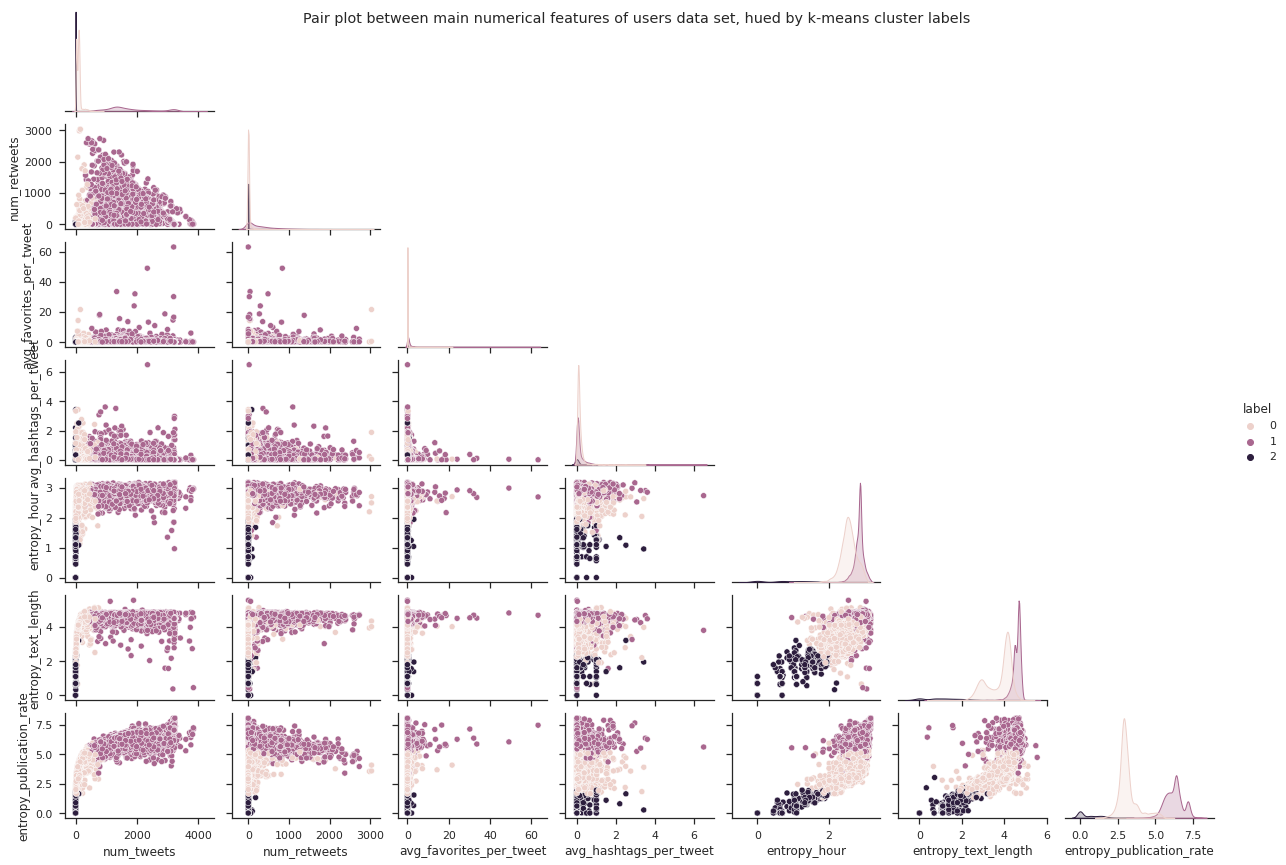

In [31]:
sn.set_theme(style="ticks")

p = sn.pairplot(users_df, 
            hue='label', 
            vars=['num_tweets', 'num_retweets', 'avg_favorites_per_tweet', 'avg_hashtags_per_tweet', 'entropy_hour', 'entropy_text_length', 'entropy_publication_rate'], 
            corner=True)

p.fig.set_size_inches(18,12)

p.fig.suptitle('Pair plot between main numerical features of users data set, hued by k-means cluster labels')

plt.show()


The bar plot below shows how the bot and genuine users are distributed among cluster. Cluster 0 has a number of genuine users almost double with respect to bots, whereas for cluster 1 (the largest) and cluster 2 (the smallest) the tendency is inverted.

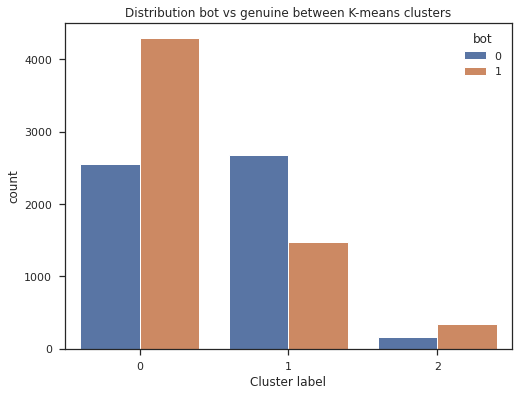

In [78]:
fig, ax = plt.subplots(figsize=(8,6)) 

sn.countplot(x=users_df['label'], hue=users_df['bot'])
plt.title('Distribution bot vs genuine between K-means clusters')
plt.xlabel('Cluster label')

plt.show()

The following plots show how the users with different languages are distributed among the clusters. To visualize better the data, I plotted three different charts: the first one takes into account all the languages, the second one excludes 'en' (which is the most frequent by large), and the third one also excludes 'it' (which is the second most frequent one).  

From the plots it is possible to see that the users with language 'en' are principally assigned to clusters 1 (most of them) and 0.  

It is interesting to see that for language 'it' (which are all bots), almost all the users are assigned to cluster 0.

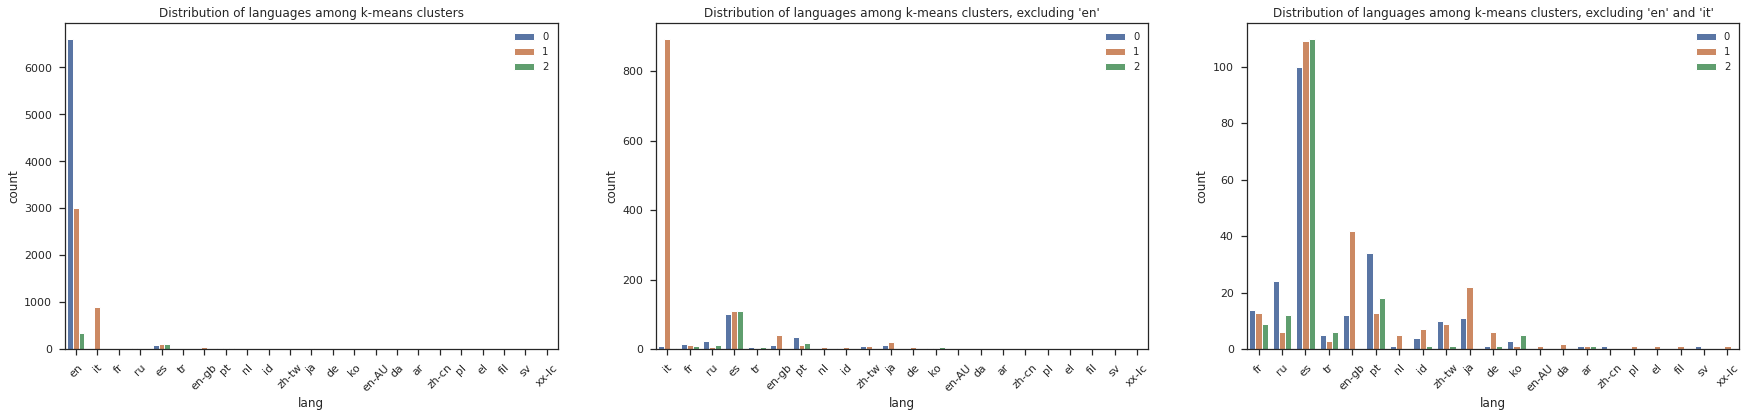

In [55]:
fig, ax = plt.subplots(1,3,figsize=[30,6])

no_en_df = users_df[users_df['lang'] != 'en']

no_en_it_df = no_en_df[no_en_df['lang'] != 'it']

sn.countplot(x=users_df['lang'], hue=users_df['label'], ax=ax[0])
ax[0].set_title('Distribution of languages among k-means clusters')
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].legend(loc='upper right', prop={'size': 10})

sn.countplot(x=no_en_df['lang'], hue=no_en_df['label'], ax=ax[1])
ax[1].set_title("Distribution of languages among k-means clusters, excluding 'en'")
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].legend(loc='upper right', prop={'size': 10})

sn.countplot(x=no_en_it_df['lang'], hue=no_en_it_df['label'], ax=ax[2])
ax[2].set_title("Distribution of languages among k-means clusters, excluding 'en' and 'it'")
ax[2].tick_params(axis='x', labelrotation=45)
ax[2].legend(loc='upper right', prop={'size': 10})

plt.show()

#### **Evaluation by external metrics**

I use the Similarity, Homogeneity, Completeness and Mutual Information metrics to evaluate the K-means clustering with K equal to 3, with respect to the categorical features 'bot' and 'lang'.
- Similarity: computed by the adjusted rand score, it gives a similarity evaluation between the categorical features and the clustering labels
- Homogeneity: measures the homogeneity of clusters with respect to the categorical features
- Completeness: measures how much the users with the same value for the categorical features are assigned to the same cluster
- Mutual Information: measures the mutual dependence between the categorical features and the clustering labels

In [56]:
kmeans_3_eval_df = pd.DataFrame()

cols = ['bot', 'lang']

kmeans_3_eval_df['Feature'] = cols
kmeans_3_eval_df['Similarity'] = [metrics.adjusted_rand_score(cat_df[col], users_df['label']) for col in cols]
kmeans_3_eval_df['Homogeneity'] = [metrics.homogeneity_score(cat_df[col], users_df['label']) for col in cols]
kmeans_3_eval_df['Completeness'] = [metrics.completeness_score(cat_df[col], users_df['label']) for col in cols]
kmeans_3_eval_df['Mutual Information'] = [metrics.normalized_mutual_info_score(cat_df[col], users_df['label'], average_method='arithmetic') for col in cols]

kmeans_3_eval_df.set_index(['Feature'], inplace=True)

kmeans_3_eval_df

,Similarity,Homogeneity,Completeness,Mutual Information
Feature,,,,
bot,0.063841,0.051106,0.043335,0.046901
lang,0.149513,0.182213,0.130471,0.152061


The results shows a relatively good performance for the 'lang' feature.

## **Density based clustering**

The density based clustering is performed using the DBScan algorithm.

### **Study of the clustering parameters**

For the DBScan algorithm is needed to set two main parameters, which are eps (maximum distance to consider two points neighbors) and minPts (minimum number of points to form a cluster).  
In order to establish the value for the parameter eps, I plot the sorted distances of every point to its 4th nearest neighbour.

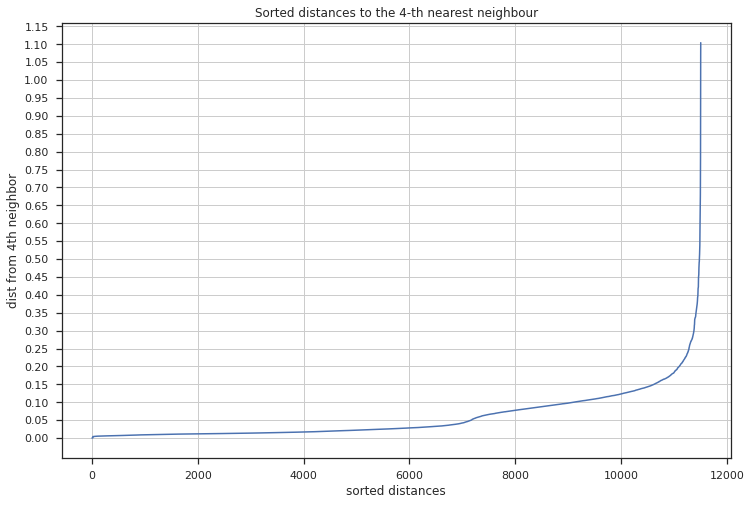

In [57]:
dist = squareform(pdist(users_norm, 'euclidean'))

fig = plt.figure(figsize=(12,8))

kth_distances = [d[np.argsort(d)[4]] for d in dist]

plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.title('Sorted distances to the 4-th nearest neighbour')
plt.ylabel('dist from 4th neighbor')
plt.xlabel('sorted distances')
plt.yticks(np.arange(0, 1.2, 0.05))
plt.grid(True)

plt.show()

From the plot of sorted distances it is possible to see that the distance is quite stable betweet 0.01 and 0.05, then there is a small step, and a gain a stable increase up to 0.2.  
From this plot then we can derive that a good value for the parameter eps is between 0.05 and 0.2. 

For the MinPts parameter instead some studies suggest that a good value for it is twice the number of features, which is 18 in our case. For completeness, I will try values for MinPts from 18 to 36 (with a step of 2).

In [58]:
len(num_df.columns)

18

I perform a complete search for the best combination of the parameters, with the ranges defined above.

In [59]:
eps_values = np.arange(0.03, 0.16, 0.01)
minPts_values = range(18, 37, 2)
dbscan_runs = [] 

for eps in eps_values: 
    for minPts in minPts_values:
      dbscan_runs.append(DBSCAN(eps=eps, min_samples=minPts))
      dbscan_runs[-1].fit(users_norm)

I create a data frame containing all parameter combinations and some statistics about them in order to choose the most promising one.

In [60]:
dbscan_comparison_df = pd.DataFrame()

dbscan_comparison_df['Eps'] = [eps for eps in eps_values for _ in minPts_values]
dbscan_comparison_df['MinPts'] = [minPts for minPts in minPts_values] * len(eps_values)
dbscan_comparison_df['Clusters'] = [(np.unique(dbscan_instance.labels_).shape[0] - 1) for dbscan_instance in dbscan_runs]
dbscan_comparison_df['Noise points'] = [list((dbscan.labels_)).count(-1) for dbscan in dbscan_runs]
dbscan_comparison_df['Cluster 0 population'] = [list((dbscan.labels_)).count(0) for dbscan in dbscan_runs]
dbscan_comparison_df['Silhouette'] = [metrics.silhouette_score(users_norm, dbscan.labels_) for dbscan in dbscan_runs]

In [61]:
dbscan_comparison_df.sort_values(by='Silhouette', ascending=False)

,Eps,MinPts,Clusters,Noise points,Cluster 0 population,Silhouette
121,0.15,20,3,1086,9925,0.367459
122,0.15,22,3,1105,9906,0.365757
123,0.15,24,3,1133,9878,0.363038
124,0.15,26,3,1157,9856,0.362412
125,0.15,28,3,1175,9840,0.361250
...,...,...,...,...,...,...
4,0.03,26,9,6114,3323,0.008677
5,0.03,28,9,6257,3323,-0.004951
6,0.03,30,8,6338,3319,-0.005666
8,0.03,34,7,6443,3317,-0.006893


In [107]:
clusterings.append({'type': 'dbscan', 'n_clusters': 3, 'eps': dbscan_comparison_df.iloc[121]['Eps'], 'minPts': dbscan_comparison_df.iloc[121]['MinPts'], 'labels': dbscan_runs[121].labels_})
dbscan = clusterings[-1]

#### **Clustering visualization**

DBScan as expected is quite good in finding outliers, marked as belonging to cluster -1. Anyway it does not seem able to create a good breakdown of the data because the cluster 0 contains almost all the points not labeled as noise, and the rest two clusters are very small.

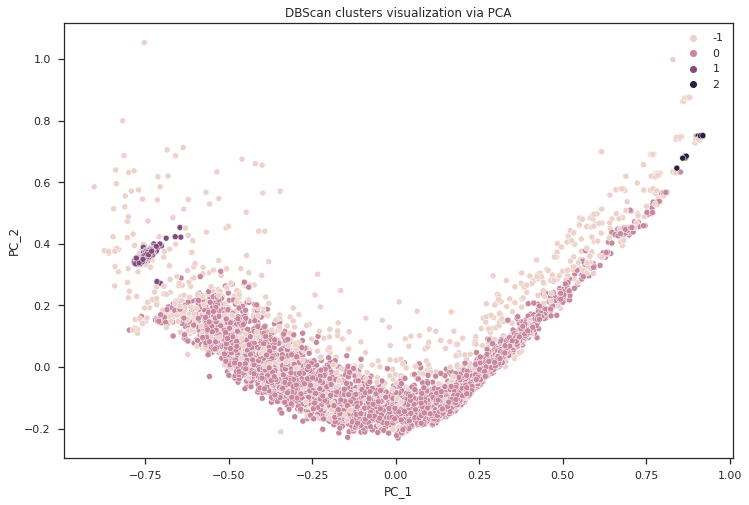

In [63]:
pca = PCA(n_components=2) 
data_to_visualize = pd.DataFrame(pca.fit_transform(users_norm), columns=['PC_1','PC_2'])

fig, ax = plt.subplots(figsize=(12,8))

ax = sn.scatterplot(x="PC_1",y="PC_2", hue=dbscan['labels'], data=data_to_visualize)
ax.set_title('DBScan clusters visualization via PCA')

plt.show()

In [64]:
users_df['dbscan_label'] = dbscan['labels']

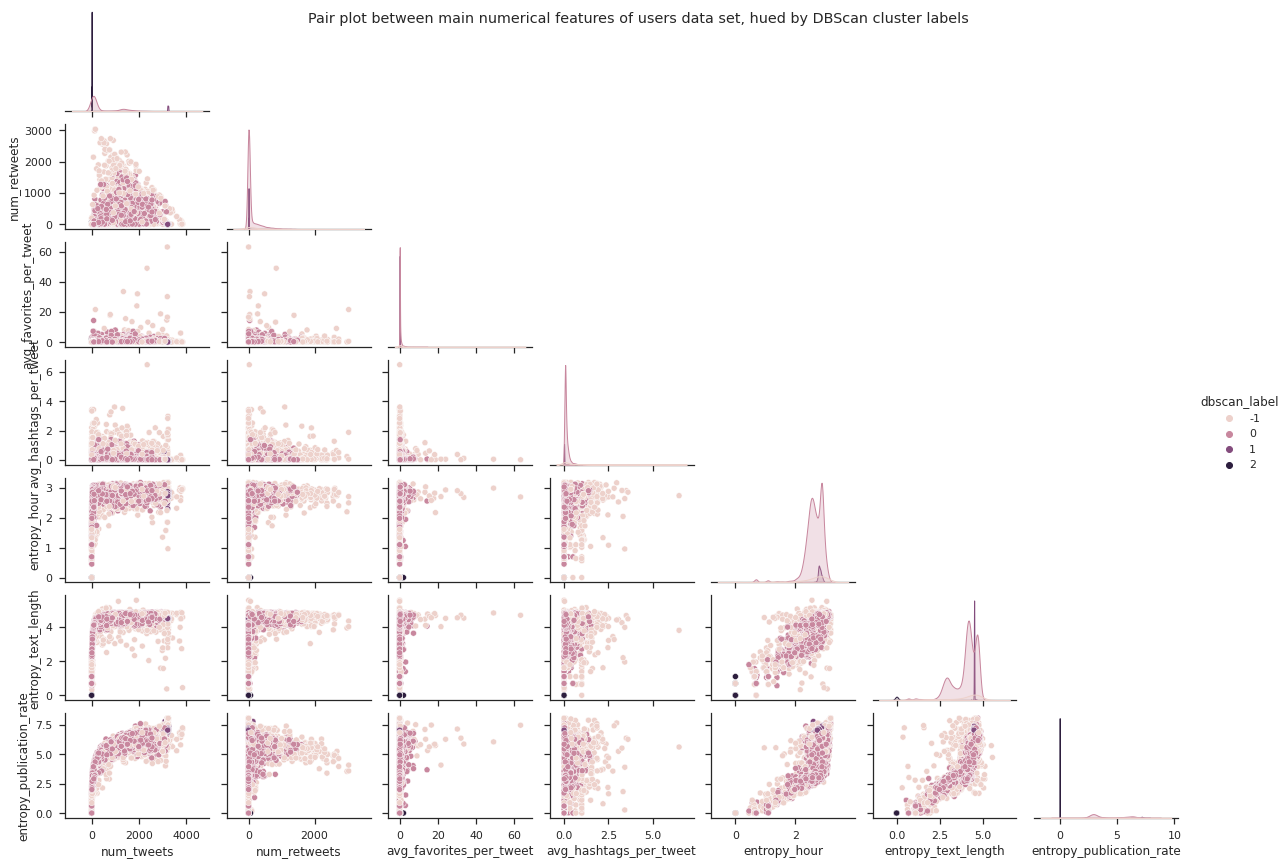

In [65]:
sn.set_theme(style="ticks")

p = sn.pairplot(users_df, 
            hue='dbscan_label', 
            vars=['num_tweets', 'num_retweets', 'avg_favorites_per_tweet', 'avg_hashtags_per_tweet', 'entropy_hour', 'entropy_text_length', 'entropy_publication_rate'], 
            corner=True)

p.fig.set_size_inches(18,12)

p.fig.suptitle('Pair plot between main numerical features of users data set, hued by DBScan cluster labels')
plt.show()


The bar plot below shows how the bot and genuine users are distributed among cluster.

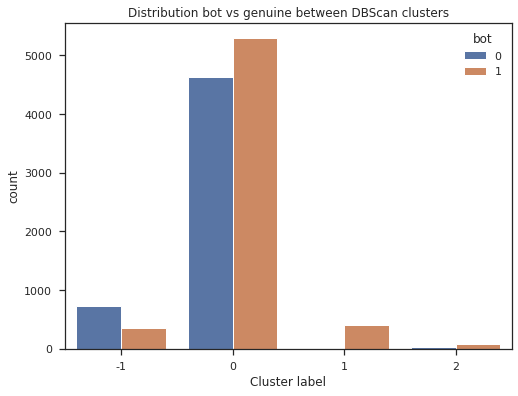

In [77]:
fig, ax = plt.subplots(figsize=(8,6)) 

sn.countplot(x=users_df['dbscan_label'], hue=users_df['bot'])
plt.title('Distribution bot vs genuine between DBScan clusters')
plt.xlabel('Cluster label')

plt.show()

#### **Evaluation**

In [67]:
dbscan_evaluation_df=pd.DataFrame(
    [[davies_bouldin_score(users_norm, dbscan['labels']),
      silhouette_score(users_norm, dbscan['labels']),
      calinski_harabasz_score(users_norm, dbscan['labels'])]],
    columns=['Davies_Bouldin', 'Silhouette', 'Calinski_Harabasz']
)

dbscan_evaluation_df

,Davies_Bouldin,Silhouette,Calinski_Harabasz
0,1.908947,0.367459,1223.8152


##### **External metrics**

I use the Similarity, Homogeneity, Completeness and Mutual Information metrics to evaluate the DBScan clustering, with respect to the categorical features 'bot' and 'lang'.

In [68]:
dbscan_ext_eval_df = pd.DataFrame()

cols = ['bot', 'lang']

dbscan_ext_eval_df['Feature'] = cols
dbscan_ext_eval_df['Similarity'] = [metrics.adjusted_rand_score(cat_df[col], users_df['dbscan_label']) for col in cols]
dbscan_ext_eval_df['Homogeneity'] = [metrics.homogeneity_score(cat_df[col], users_df['dbscan_label']) for col in cols]
dbscan_ext_eval_df['Completeness'] = [metrics.completeness_score(cat_df[col], users_df['dbscan_label']) for col in cols]
dbscan_ext_eval_df['Mutual Information'] = [metrics.normalized_mutual_info_score(cat_df[col], users_df['dbscan_label'], average_method='arithmetic') for col in cols]

dbscan_ext_eval_df.set_index(['Feature'], inplace=True)

dbscan_ext_eval_df

,Similarity,Homogeneity,Completeness,Mutual Information
Feature,,,,
bot,0.005117,0.044650,0.060776,0.051479
lang,0.056706,0.047376,0.054456,0.050670


From the results it seems that density based clustering is not particularly suited for our dataset.

## **Hierarchical clustering**

I build the dendogram using four different linkage methods:
- single (MIN)
- complete (MAX)
- average
- Ward 

In [82]:
methods = ['single', 'complete', 'average', 'ward']

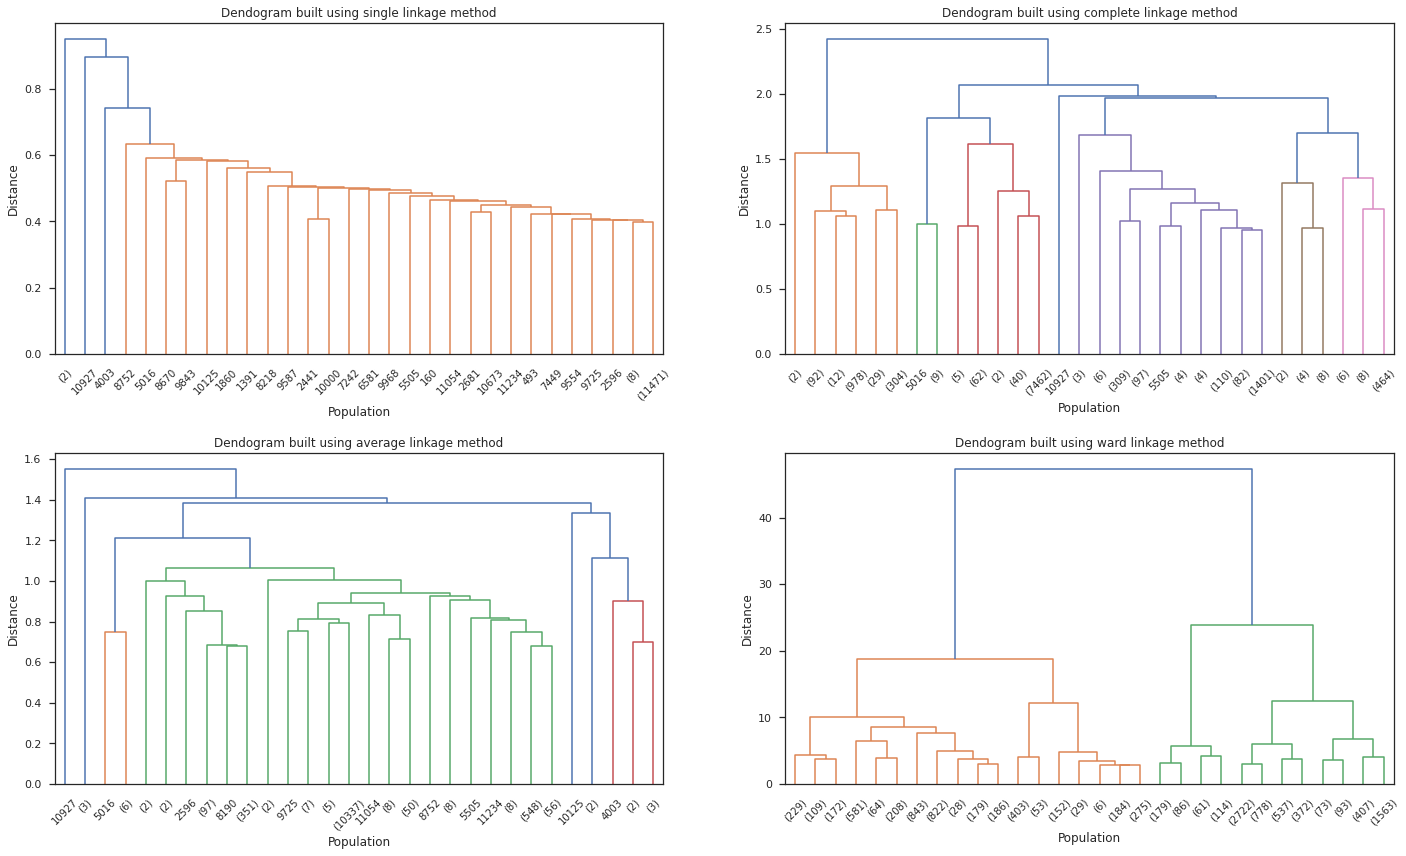

In [89]:
fig, axes = plt.subplots(2, 2, figsize=(24, 14))
data_dist = pdist(users_norm, metric='euclidean')

plt.subplots_adjust(hspace=0.3)

for i, row in enumerate(np.reshape(methods, (2,2))):
  for j, method in enumerate(row):
    data_link = linkage(data_dist, method=method, metric='euclidean')
    dn = dendrogram(data_link, ax=axes[i][j], truncate_mode='lastp')
    axes[i][j].set_title('Dendogram built using {} linkage method'.format(method))
    axes[i][j].set_xlabel('Population')
    axes[i][j].set_ylabel('Distance')

plt.show()

**Single**: There are many singletons and a big cluster containing 11471 elements, it does not seem a good choice  
**Complete**: Cutting at 2 divides the data in three clusters, a bigger one (~ 7500 points), and two smaller ones (~ 1400 and ~ 2500 points)  
**Average**: Similar to *Single*, does not seem a good choice  
**Ward**:  Cutting at 20 produces three clusters (4500 / 400 / 6600 points)  

The complete and ward seem the best options.

Now I compute the clusters by agglomerative clusterings, using the number of cluster (which is required in this implementation) identified in the previous phase.

In [90]:
methods.remove('single')
n_clusters = {'complete': 3, 'average': 6, 'ward': 3}

In [72]:
hierarchical_clustering_labels = {}
for method in methods:
  hierarchical_clustering_labels[method] = AgglomerativeClustering(n_clusters=n_clusters[method], affinity='euclidean', linkage=method).fit_predict(users_norm)

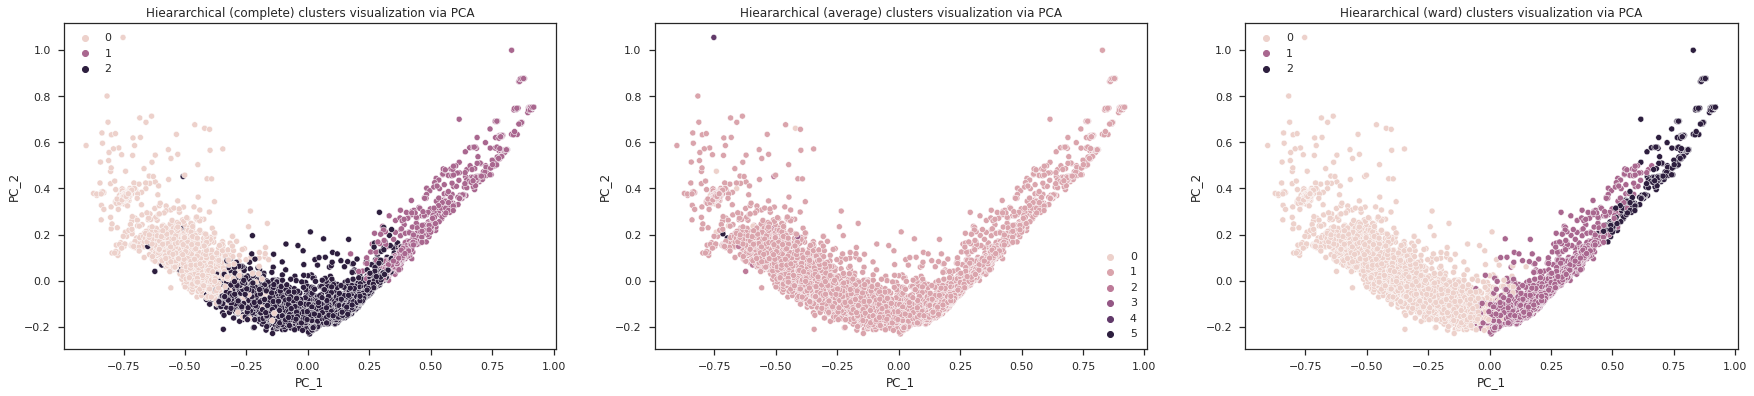

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(30, 6))

pca = PCA(n_components=2) 
df_to_visualize = pd.DataFrame(pca.fit_transform(users_norm), columns=['PC_1','PC_2'])

for i, method in enumerate(methods):
  sn.scatterplot(ax=axes[i], x="PC_1",y="PC_2", hue=hierarchical_clustering_labels[method], data=df_to_visualize);
  axes[i].set_title('Hieararchical ({}) clusters visualization via PCA'.format(method))

As expected, the clustering using the average linkage method did not produce significant results.

In [74]:
for method in methods:
  users_df['hierarchical_{}_label'.format(method)] = hierarchical_clustering_labels[method]

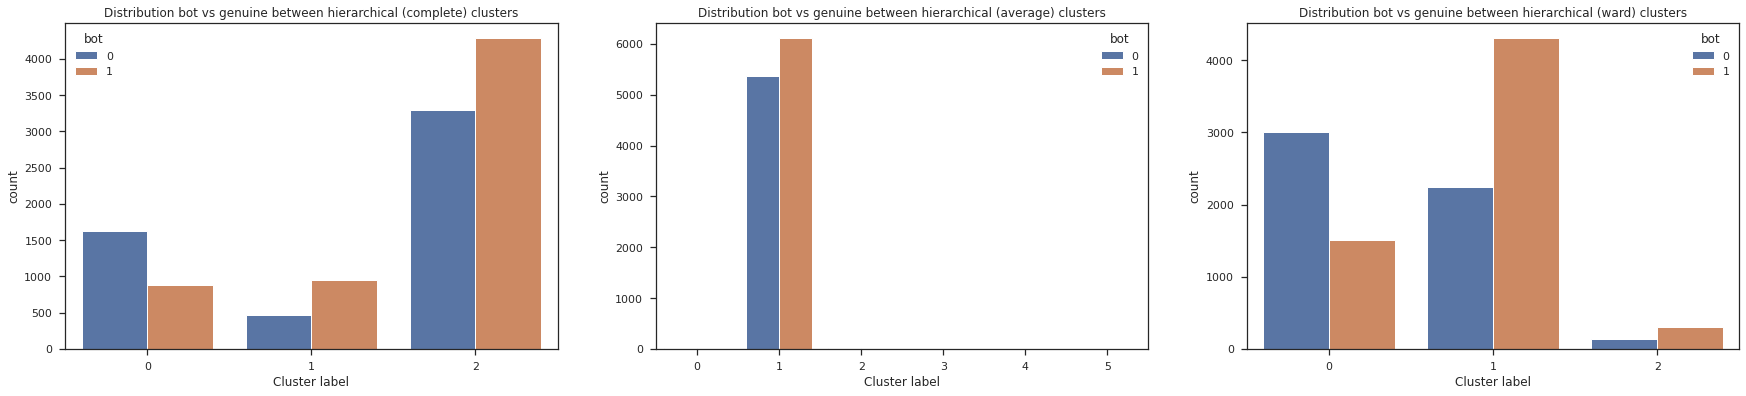

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(30, 6))


for i, method in enumerate(methods):
  sn.countplot(x=users_df['hierarchical_{}_label'.format(method)], hue=users_df['bot'], ax = axes[i])
  axes[i].set_title('Distribution bot vs genuine between hierarchical ({}) clusters'.format(method))
  axes[i].set_xlabel('Cluster label')

plt.show()

For the ward linkage method, in cluster 1 there is a marked predominance of bot users.

#### **Evaluation**

The Cophenetic Correlation Coefficient (CPCC) is the correlation between
the entries of this matrix and the original dissimilarity matrix and is a standard
measure of how well a hierarchical clustering (of a particular type) fits the
data. One of the most common uses of this measure is to evaluate which type
of hierarchical clustering is best for a particular type of data.

In [91]:
hierarchical_eval_df = pd.DataFrame()

hierarchical_eval_df['Linkage'] = methods
hierarchical_eval_df['Davies_Bouldin'] = [davies_bouldin_score(users_norm, hierarchical_clustering_labels[method]) for method in methods]
hierarchical_eval_df['Silhouette'] = [silhouette_score(users_norm, hierarchical_clustering_labels[method]) for method in methods]
hierarchical_eval_df['Calinski_Harabasz'] = [calinski_harabasz_score(users_norm, hierarchical_clustering_labels[method]) for method in methods]
hierarchical_eval_df['CPCC'] = [np.corrcoef(pdist(users_norm), cophenet(linkage(users_norm, method)))[0][1] for method in methods]

hierarchical_eval_df.set_index(['Linkage'], inplace=True)
hierarchical_eval_df

,Davies_Bouldin,Silhouette,Calinski_Harabasz,CPCC
Linkage,,,,
complete,1.050457,0.335444,6108.620495,0.668755
average,0.674971,0.545787,29.431207,0.872825
ward,0.714640,0.527053,9117.141303,0.681873


The average method scores good for Davies-Bouldin and Silhouette because it divides the dataset principally in one cluster, and then the results are not so significant (in fact it is very poor in the Calinski-Harabasz score)

The ward method instead seems to be the best method.

In [108]:
clusterings.append({'type': 'hierarchical (ward)', 'linkage': 'ward', 'n_clusters': 3, 'labels': hierarchical_clustering_labels['ward']})

##### **External metrics**

I use the Similarity, Homogeneity, Completeness and Mutual Information metrics to evaluate the Hierarchical clustering with the Ward linkage method, with respect to the categorical features 'bot' and 'lang'.

In [93]:
hierarchical_eval_ext_df = pd.DataFrame()

cols = ['bot', 'lang']

hierarchical_eval_ext_df['Feature'] = cols
hierarchical_eval_ext_df['Similarity'] = [metrics.adjusted_rand_score(cat_df[col], users_df['hierarchical_ward_label']) for col in cols]
hierarchical_eval_ext_df['Homogeneity'] = [metrics.homogeneity_score(cat_df[col], users_df['hierarchical_ward_label']) for col in cols]
hierarchical_eval_ext_df['Completeness'] = [metrics.completeness_score(cat_df[col], users_df['hierarchical_ward_label']) for col in cols]
hierarchical_eval_ext_df['Mutual Information'] = [metrics.normalized_mutual_info_score(cat_df[col], users_df['hierarchical_ward_label'], average_method='arithmetic') for col in cols]

hierarchical_eval_ext_df.set_index(['Feature'], inplace=True)

hierarchical_eval_ext_df

,Similarity,Homogeneity,Completeness,Mutual Information
Feature,,,,
bot,0.095147,0.074431,0.063293,0.068412
lang,0.116052,0.164769,0.118318,0.137733


## Clustering comparison

In [109]:
clustering_comparison_df = pd.DataFrame()

clustering_comparison_df['Type'] = [clustering['type'] for clustering in clusterings]
clustering_comparison_df['Number_of_clusters'] = [clustering['n_clusters'] for clustering in clusterings]
clustering_comparison_df['Davies_Bouldin'] = [davies_bouldin_score(users_norm, clustering['labels']) for clustering in clusterings]
clustering_comparison_df['Silhouette'] = [silhouette_score(users_norm, clustering['labels']) for clustering in clusterings]
clustering_comparison_df['Calinski_Harabasz'] = [calinski_harabasz_score(users_norm, clustering['labels']) for clustering in clusterings]

clustering_comparison_df.set_index(['Type'], inplace=True)
clustering_comparison_df

,Number_of_clusters,Davies_Bouldin,Silhouette,Calinski_Harabasz
Type,,,,
kmeans,8,1.059017,0.404314,7355.954167
kmeans,3,0.718478,0.541799,9812.475244
dbscan,3,1.908947,0.367459,1223.815200
hierarchical (ward),3,0.714640,0.527053,9117.141303
